# Thermodynamics of Thiocyanate Anions in Water and at the Air-Water Interface - Analysis (SI)

## Loading modules

In [1]:
%matplotlib inline
from IPython.display import display, Image, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import os
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Loading/computing and plotting the RDFs 

Here, we define a function loading/computing and plotting the radial distribution functions (RDFs) later used to calculate excess coordination numbers. 

In [2]:
def plotRDFs(ff,waterModel,cation,anion,rdfAtom,conc,subplot):
    
    """ This function loads and plots RDFs and takes seven arguments:
    - ff: 'ff_our' or 'ff_bian'
    - waterModel: 'spce', 'opc3' or 'tip4pew'
    - cation: 'K' or 'Na'
    - anion: 'SCN', 'I' or 'Cl'
    - rdfAtom: 'S', 'C', 'N', 'I' or 'Cl
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (choose depending on length of trajectory or number of block files stored)
    block_range = np.arange(1,11,1)

    cnt = 0 # Initializing index to make trajectory only to be read once
    
    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+ff+'/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    
    for block in block_range: # Looping over blocks  

        # if pickle files exist, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
        
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md

                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            endFrac = 1 - startFrac
            first = nbrFrames*startFrac + (block-1)*(nbrFrames*endFrac)/len(block_range)
            last = nbrFrames*startFrac + block*(nbrFrames*endFrac)/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range)
            g_wc_avg = g_wc_avg+g_wc/len(block_range)

            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block)], [g_cc, g_wc, r]):

                np.savetxt(file_name, var)
                print("next check...")
            
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
    subplot.plot(r,g_cc_avg, label="$g_{cc}(r)$", color='magenta')
    subplot.plot(r,g_wc_avg, label="$g_{wc}(r)$", color='blue')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$g(r)$", fontsize=18)

## Plotting RDFs
Here, we plot the RDFs for the selected forcefield, watermodel and ion pairs.

Selected forcefield: ff_our 
Selected water model: spce


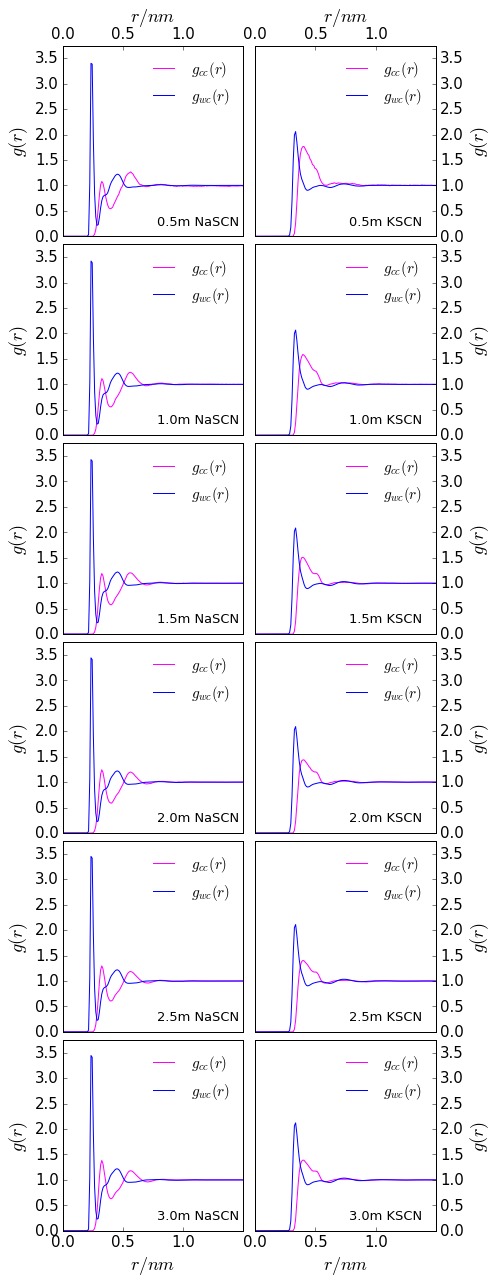

In [3]:
ffs = ['ff_our', 'ff']
ff = ffs[0]

waterModels = ['spce', 'opc3', 'tip4pew']
waterModel = waterModels[0]

cations = ['Na', 'K']
anion = 'SCN'
rdfAtom = 'C' # Choose which atom in the anion to compute distances from
concs = np.linspace(start=0.5, stop=3.0, num=6)

print('Selected forcefield:', ff, '\nSelected water model:', waterModel)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((7, 18))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotRDFs(ff,waterModel,cations[j],anion,rdfAtom,concs[i],ax)
        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.52,.06), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)

        else:
            ax.xaxis.tick_bottom()

        
        plt.xlim((0, 1.5))
        plt.ylim((0, 3.75))
        plt.xticks(np.arange(0,1.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc=1, fontsize=15,frameon=False)
        plt.tight_layout(w_pad=0.0,h_pad=0.0)

## Compute excess coordination numbers
Here, the method to calculate the excess coordination numbers, $N_{cc}(r)$ and $N_{cc}(r)$, is defined. The property that is plotted is denoted $\Gamma(r)$, and is defined as

\begin{align}
\Gamma(r) = N_{cc}(r) - N_{wc}(r)
\tag{6}
\end{align}

This property is later used to calculate $a_{c}'$.

In [4]:
def plotExcCoordNbrs(ff,waterModel,cation,anion,rdfAtom,conc,subplot):
    
    """ This function computes and plots the excess coordination numbers and takes six arguments:
    - ff: 'ff_our' or 'ff_bian'
    - waterModel: 'spce', 'opc3' or 'tip4pew'
    - cation: 'K' or 'Na'
    - anion: 'SCN', 'I' or 'Cl'
    - rdfAtom: 'S', 'C', 'N', I' or 'Cl'
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,11,1)

    cnt = 0 # Initializing index to make trajectory only to be read once

    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+ff+'/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md
                
                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            end = nbrFrames - start
            first = start + (block-1)*end/len(block_range)
            last = start + block*end/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf
            
            # Computing volume using box vectors
            V = 0
            for vec in traj.unitcell_lengths:
                V = V + vec[0]*vec[1]*vec[2] / traj.n_frames # Volume for current block

            V_avg = V_avg + V/len(block_range) # Average volume (nm³)
            
            # Computing number density of ions
            rho_c = N_c / V # Average number density of ions (nm⁻³)
            rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
            
            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_cc, g_wc, r, V, rho_c]):

                if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)):
                    f = open( file_name, 'w' )
                    f.write( repr(var) + '\n' )
                    f.close()
                    print("pickle", file_name, "created")
                else: 
                    np.savetxt(file_name, var)
                    print("pickle", file_name, "created")
        
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
            
        # In this step, the coordination numbers are calculated

        # Getting increment in array with radii 
        dr = r[1]-r[0]
        
        # Calculating coordination number without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma = N_cc - N_wc
        
        # Calculating gamma function
        Gamma = N_cc - N_wc
    
    subplot.plot(r,Gamma,color='r', label='Uncorrected')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=18)

## Plotting $\Gamma$
Here, we plot the function $\Gamma$ for the selected forcefield, watermodel and ion pairs, without any correction factor applied.

Selected forcefield: ff_our 
Selected water model: spce


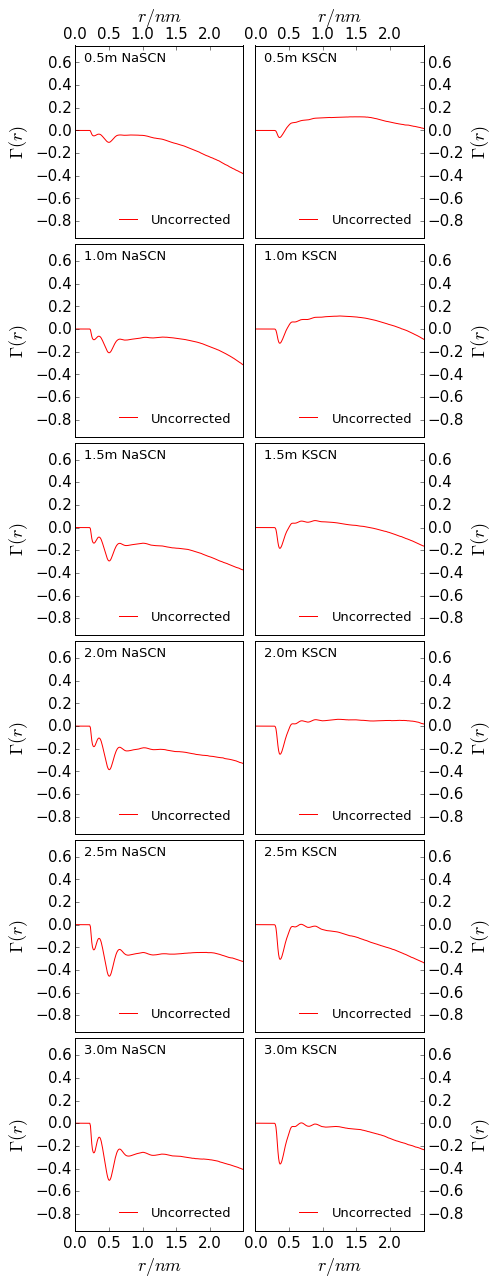

In [5]:
ffs = ['ff_our', 'ff_bian']
ff = ffs[0]

waterModels = ['spce', 'opc3', 'tip4pew']
waterModel = waterModels[0]

cations = ['Na', 'K']

anions = ['SCN','I','Cl']
anion = anions[0]
rdfAtom = 'S'

print('Selected forcefield:', ff, '\nSelected water model:', waterModel)

concs = np.linspace(start=0.5, stop=3.0, num=6)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((7, 18))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotExcCoordNbrs(ff,waterModel,cations[j],anion,rdfAtom,concs[i],ax)
        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.05,.92), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)
        
        else:
            ax.xaxis.tick_bottom()
        
        plt.xlim((0, 2.5))
        plt.ylim((-0.95, 0.75))
        plt.xticks(np.arange(0,2.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(loc=4, fontsize=13, frameon=False)
        plt.tight_layout(w_pad=0,h_pad=0.6)

## Corrected excess coordination numbers
Here, we add a correction factor to account for the issue asociated with the finite size of simulated systems.

In [6]:
def plotExcCoordNbrsCorrected(ff,waterModel,cation,anion,rdfAtom,conc,corrIndex,subplot):
    
    """ This function computes and plots the excess coordination numbers and takes eight arguments:
    - ff: 'ff_our' or 'ff_bian'
    - waterModel: 'spce', 'opc3' or 'tip4pew'
    - cation: 'K' or 'Na'
    - anion: 'SCN', 'I' or 'Cl'
    - rdfAtom: 'S', 'C', 'N', I' or 'Cl'
    - conc - 0.5, 1.0, 1.5, 2.0, 2.5, 3.0 (m)
    - corrIndex - i.e. correction factor: 'Hess' or 'Kruger'
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    cnt = 0 # Initializing index to make trajectory only to be read once

    index = 0 # Initializing concentration index                     
        
    wdir_exp_data = WORKDIR+'/data/'+ff+'/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
    wdir_sim_data = wdir_exp_data+str(conc)+'m/'

    ind = 0 # Initializing block index

    g_cc_avg = 0 # Initializing radial distribution function of ion around ion
    g_wc_avg = 0 # Initializing radial distribution function of ion around water
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0

    for block in block_range: # Looping over blocks  

        # if pickle file exists, use that
        if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):        
            
            # Loading stored files from directory
            g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
            g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
            
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):
            
            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md
                
                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                
                sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)
   
                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)
                
                cnt = cnt + 1
            
            startFrac = start / nbrFrames

            end = nbrFrames - start
            first = start + (block-1)*end/len(block_range)
            last = start + block*end/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80
            
            pair_cc = traj.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
            pair_wc = traj.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
            r, g_cc = md.compute_rdf(traj, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            r, g_wc = md.compute_rdf(traj, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
            corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
            g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

            g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
            g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf
            
            # Computing volume using box vectors
            V = 0
            for vec in traj.unitcell_lengths:
                V = V + vec[0]*vec[1]*vec[2] / traj.n_frames # Volume for current block

            V_avg = V_avg + V/len(block_range) # Average volume (nm³)
            
            # Computing number density of ions
            rho_c = N_c / V # Number density of ions for current block (nm⁻³)
            rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
            
            for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_cc, g_wc, r, V, rho_c]):

                if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)):
                    f = open( file_name, 'w' )
                    f.write( repr(var) + '\n' )
                    f.close()
                    print("pickle", file_name, "created")
                else: 
                    np.savetxt(file_name, var)
                    print("pickle", file_name, "created")
        
        
        
        else:

            print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")
        
        
    # In this step, the coordination numbers using the two different correction factors are calculated

    # Getting increment in array with radii 
    dr = r[1]-r[0]

    # Defining the truncation distance 
    truncInd = 100
    R = r[truncInd] # Equals 1.0 nm

    # Calculating remaining volume as a function of the radius
    Vn = 4*pi/3*r**3 / V_avg

    # Calculating the total number of ions in the box 
    N_c = rho_c_avg*V_avg

    # Calculating coordination number without correction factor
    N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
    N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
    Gamma = N_cc - N_wc

    # Calculating Hess correction factors, corresponding rdf:s and coordination numbers, full trajectory
    if corrIndex is 'Hess':
        corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
        corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
        g_cc_avg = g_cc_avg * corr_cc
        g_wc_avg = g_wc_avg * corr_wc
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        plotColor = 'green' 

    # Calculating coordination numbers with Krüger correction factor, full trajectory
    elif corrIndex is 'Kruger':
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
        plotColor = 'blue'

    # Calculating gamma function
    Gamma = N_cc - N_wc

    subplot.plot(r,Gamma,color=plotColor,label='Corrected ('+corrIndex+')')
    subplot.set_xlabel("$r/nm$", fontsize=18)
    subplot.set_ylabel("$\Gamma(r)$", fontsize=18)

## Plotting $\Gamma$ based on scaled RDFs

Here, we plot the function $\Gamma$ for the selected forcefield, watermodel and ion pairs, with and without any correction factor applied.

Chosen forcefield: ff_our 
Chosen water model: spce


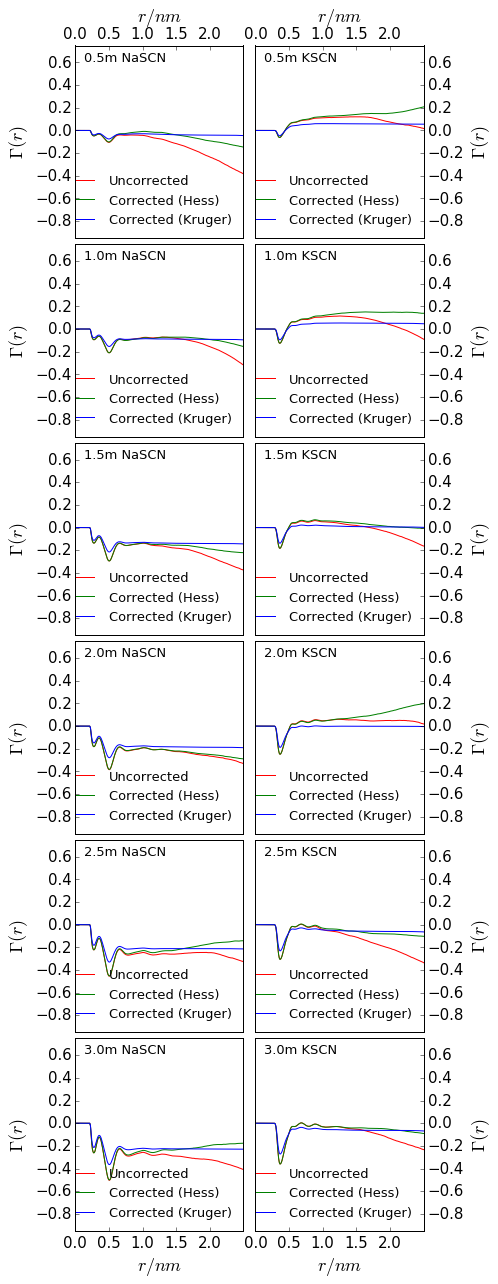

In [7]:
ffs = ['ff_our', 'ff_bian']
ff = ffs[0]

waterModels = ['spce', 'opc3', 'tip4pew']
waterModel = waterModels[0]

cations = ['Na', 'K']

anions = ['SCN','I','Cl']
anion = anions[0]

rdfAtom = 'C'

print('Chosen forcefield:', ff, '\nChosen water model:', waterModel)
concs = np.linspace(start=0.5, stop=3.0, num=6)

n_rows = len(concs)
n_cols = len(cations)


fig_dim = np.array((7, 18))
fig = plt.figure(figsize=fig_dim)

for i in range(n_rows):
    for j in range(n_cols):
        ax = fig.add_subplot(n_rows,n_cols,(j+1)+n_cols*i)
        plotExcCoordNbrs(ff,waterModel,cations[j],anion,rdfAtom,concs[i],ax)
        plotExcCoordNbrsCorrected(ff,waterModel,cations[j],anion,rdfAtom,concs[i],'Hess',ax)
        plotExcCoordNbrsCorrected(ff,waterModel,cations[j],anion,rdfAtom,concs[i],'Kruger',ax)

        ax.annotate(str(concs[i])+'m '+cations[j]+anion,xy=(.05,.92), fontsize=13, xycoords='axes fraction')
        
        if j == 0:
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            
        elif 0<i<5:
            ax.xaxis.set_visible(False)
        
        else:
            ax.xaxis.tick_bottom()
        
        
        plt.xlim((0, 2.5))
        plt.ylim((-0.95, 0.75))
        plt.xticks(np.arange(0,2.5,0.5), fontsize=15)
        plt.yticks(fontsize=15)
        
        plt.legend(loc=4, fontsize=13, frameon=False)
            
        plt.tight_layout(w_pad=0,h_pad=0.6)

## Calculating the wanted property,  $a_{c}'$

In the next two cells, we calculate and plot the activity derivative, $a_{c}'$, based on the corrected excess coordination numbers.

In [8]:
def actDer(ff,waterModel,cation,anion,rdfAtom,corrIndex,subplot):
    
    """ This function plots activity derivatives and takes seven arguments:
    - ff: 'ff_our' or 'ff_bian'
    - waterModel: 'spce', 'opc3' or 'tip4pew'
    - cation: 'K' or 'Na'
    - anion: 'SCN', 'I' or 'Cl'
    - rdfAtom: 'S', 'C', 'N', I' or 'Cl'
    - corrIndex - i.e. correction factor: 'Hess' or 'Kruger'
    - subplot (i.e. where the subplot will appear)
    """
    
    WORKDIR = %pwd

    #print(WORKDIR)
    
    # Defining molar mass of water (kg/mol)
    MW_H2O = 18.01528e-3
    
    # Listing avalable molal concentrations (mol/(kg solvent))
    concs_m = np.linspace(start=0.5, stop=3.0, num=6) 

    # Creating array with indices of blocks available (in total 18 blocks)
    block_range = np.arange(1,19,1)

    # Declaring variables that will be calculated later
    molar = np.empty([1, len(concs_m)]) # molar concentrations [mol/l]
    molal = np.empty([1, len(concs_m)]) # molal concentrations [mol/(kg solvent)]
    actDer = np.empty([len(block_range),len(concs_m)]) # activity derivatives per block
    actDerErr = np.empty([2, len(concs_m)]) # standard deviation among blocks
    actDerAvg = np.empty([1,len(concs_m)]) # activity derivative, full trajectory

    cnt = 0 # Initializing index to make trajectory only to be read once
    
    index = 0 # Initializing concentration index

    for conc_m in concs_m: # Looping over concentrations                      
        
        wdir_exp_data = WORKDIR+'/data/'+ff+'/'+waterModel+'/'+cation.lower()+anion.lower()+'/'
        wdir_sim_data = WORKDIR+'/data/'+ff+'/'+waterModel+'/'+cation.lower()+anion.lower()+'/'+str(conc_m)+'m/'
        ind = 0 # Initializing block index

        g_cc_avg = 0 # Initializing radial distribution function of ion around ion
        g_wc_avg = 0 # Initializing radial distribution function of ion around water
        V_avg = 0 # Initializing volume of the system
        rho_c_avg = 0 # Initializing salt density of system    
        rho_w_avg = 0 # Initializing water density of system    
        
        for block in block_range: # Looping over blocks  
            
            # if pickle file exists, use that
            if os.path.isfile( wdir_sim_data+'g_cc_'+str(block) ) and os.path.isfile( wdir_sim_data+'g_wc_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_w_'+str(block) ):        

                #print("Loading from saved pickle")

                # Loading stored files from directory
                g_cc = np.loadtxt(wdir_sim_data+'g_cc_'+str(block))
                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Calculating average among blocks
                g_wc = np.loadtxt(wdir_sim_data+'g_wc_'+str(block))
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Calculating average among blocks
                r = np.loadtxt(wdir_sim_data+'r_'+str(block))
                V = np.loadtxt(wdir_sim_data+'V_'+str(block))
                V_avg = V_avg + V/len(block_range) # Calculating average among blocks
                rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
                rho_c_avg = rho_c_avg + rho_c/len(block_range)
                rho_w = np.loadtxt(wdir_sim_data+'rho_w_'+str(block))
                rho_w_avg = rho_w_avg + rho_w/len(block_range)

            # if simulation output files exist, use those
            elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):

                # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
                while (cnt < 1):
                    
                    import mdtraj as md
                    
                    struct = md.load_pdb(wdir_sim_data+'out.pdb')
                    N_c = len(struct.topology.select('name '+rdfAtom+' or name '+cation)) # Number of ions
                    N_w = len(struct.topology.select('name O')) # Number of water molecules
                    
                    sel = struct.topology.select('name O or name '+cation+' or name '+rdfAtom)

                    print("Reading in trajectory...")
                    traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                    nbrFrames = traj.n_frames
                    start = nbrFrames/10
                    traj_equil = traj[start:nbrFrames]
                    print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)

                    cnt = cnt + 1

                startFrac = start / nbrFrames

                end = nbrFrames - start
                first = start + (block-1)*end/len(block_range)
                last = start + block*end/len(block_range)

                traj_block = traj[first:last]
                print("Number of frames in trajectory block: ", traj_block.n_frames)

                # Analysis: Calculating RDFs
                r_max = 2.80

                pair_cc = traj.topology.select_pairs('name '+cation+' or name '+rdfAtom, 'name '+cation+' or name '+rdfAtom)
                pair_wc = traj.topology.select_pairs('name O', 'name '+cation+' or name '+rdfAtom)
                r, g_cc = md.compute_rdf(traj, pair_cc, r_range=[0,r_max], bin_width=0.01, periodic=True)
                r, g_wc = md.compute_rdf(traj, pair_wc, r_range=[0,r_max], bin_width=0.01, periodic=True)
                corr = len(pair_cc) / (0.5*N_c**2) # correction applied to account for diagonal in pair matrix
                g_cc = g_cc * corr # re-scale ion-ion rdf in order to take account for diagonal in pair matrix

                g_cc_avg = g_cc_avg+g_cc/len(block_range) # Average ion-ion rdf
                g_wc_avg = g_wc_avg+g_wc/len(block_range) # Average water-ion rdf

                # Computing volume using box vectors
                V = 0
                for vec in traj.unitcell_lengths:
                    V = V + vec[0]*vec[1]*vec[2] / traj.n_frames # Volume for current block

                V_avg = V_avg + V/len(block_range) # Average volume (nm³)

                # Computing number density of ions
                rho_c = N_c / V # Number density of ions in current block (nm⁻³)
                rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of ions (nm⁻³)
                
                # Computing number density of water
                rho_w = N_w / V # Number density of water in current block (nm⁻³)
                rho_w_avg = rho_w_avg + rho_w/len(block_range) # Average number density of water (nm⁻³)
                
                for (file_name, var) in zip([wdir_sim_data+'g_cc_'+str(block), wdir_sim_data+'g_wc_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block), wdir_sim_data+'rho_w_'+str(block)], [g_cc, g_wc, r, V, rho_c, rho_w]):

                    if file_name in (wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block), wdir_sim_data+'rho_w_'+str(block)):
                        f = open( file_name, 'w' )
                        f.write( repr(var) + '\n' )
                        f.close()
                        print("pickle", file_name, "created")
                    else: 
                        np.savetxt(file_name, var)
                        print("pickle", file_name, "created")

            else:
                print("The necessary files are not available in the searched directory (", wdir_sim_data, ")")

            # In this step, the coordination numbers using the two different correction factors are calculated

            # Defining the truncation distance 
            truncInd = 100
            R = r[truncInd] # Equals 1.0 nm

            # Getting increment in array with radii 
            dr = r[1]-r[0]

            # Calculating coordination number without correction factor
            N_cc = rho_c * 4 * pi * np.cumsum( ( g_cc - 1 ) * r ** 2 * dr )
            N_wc = rho_c * 4 * pi * np.cumsum( ( g_wc - 1 ) * r ** 2 * dr )
            Gamma = N_cc - N_wc

            # Calculating remaining volume as a function of the radius
            Vn = 4*pi/3*r**3 / V

            N_c = rho_c*V
            N_w = rho_w*V    

            # Calculating Hess correction factors, corresponding rdf:s and coordination numbers
            if corrIndex is 'Hess':
                corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
                corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
                g_ccc = g_cc * corr_cc
                g_wcc = g_wc * corr_wc
                N_ccc = rho_c * 4 * pi * np.cumsum( ( g_ccc - 1 ) * r ** 2 * dr )
                N_wcc = rho_c * 4 * pi * np.cumsum( ( g_wcc - 1 ) * r ** 2 * dr )


            # Calculating coordination number with Krüger correction factor 
            elif corrIndex is 'Kruger':
                N_ccc = rho_c * 4 * pi * np.cumsum( ( g_cc - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
                N_wcc = rho_c * 4 * pi * np.cumsum( ( g_wc - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )

            # Calculating gamma function
            Gammac = N_ccc - N_wcc 

            # Obtaining value of Gamma function used to calculate the activity derivative, Hess correction
            if corrIndex is 'Hess':
                Gammac_plateau=Gammac[truncInd]

            # Obtaining value of Gamma function used to calculate the activity derivative, Krüger correction
            elif corrIndex is 'Kruger':
                Gammac_plateau=Gammac[2*truncInd]

            # Calculating activity derivative for the current block and concentration (ind, index)
            actDer[ind, index] = 1 / ( 1 + Gammac_plateau )

            # Increasing block index with 1
            ind = ind + 1

        # Calculating average coordination numbers without correction factor
        N_cc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * dr )
        N_wc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * dr )
        Gamma_avg = N_cc - N_wc

        # Calculating Hess correction factors, corresponding rdf:s and coordination numbers, full trajectory
        if corrIndex is 'Hess':
            corr_cc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_cc - 1 )
            corr_wc = N_c * ( 1 - Vn ) / ( N_c * ( 1 - Vn ) - N_wc - 0 )
            g_ccc_avg = g_cc_avg * corr_cc
            g_wcc_avg = g_wc_avg * corr_wc
            N_ccc = rho_c_avg * 4 * pi * np.cumsum( ( g_ccc_avg - 1 ) * r ** 2 * dr )
            N_wcc = rho_c_avg * 4 * pi * np.cumsum( ( g_wcc_avg - 1 ) * r ** 2 * dr )

        # Calculating coordination numbers with Krüger correction factor, full trajectory
        elif corrIndex is 'Kruger':
            N_ccc = rho_c_avg * 4 * pi * np.cumsum( ( g_cc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )
            N_wcc = rho_c_avg * 4 * pi * np.cumsum( ( g_wc_avg - 1 ) * r ** 2 * (1-3*r/(4*R)+r**3/(16*R**3)) * dr )

        # Calculating gamma function, used to calculate the activity derivative
        Gammac_avg = N_ccc - N_wcc 

        # Calculating the activity derivative for the current concentration and correction
        if corrIndex is 'Hess':
            # Truncating the integral according to the Hess correction
            Gammac_plateau_avg = Gammac_avg[truncInd] 
            # Obtaining the activity derivative, Hess correction
            actDerAvg[0, index] = 1 / ( 1 + Gammac_plateau_avg ) 
        elif corrIndex is 'Kruger': 
            # Truncating the integral according to the Krüger correction
            Gammac_plateau_avg = Gammac_avg[2*truncInd] 
            # Obtaining the activity derivative, Krüger correction
            actDerAvg[0, index] = 1 / ( 1 + Gammac_plateau_avg ) 

        molal[0, index] = N_c/(2*N_w*MW_H2O) # Obtaining molality, based on system quantities

        # Obtaining the standard deviation among blocks of activity derivatives,
        actDerErr[0, index] = np.std(actDer[:, index]) 
        # where one is later plotted upwards from the mean value and the other downwards
        actDerErr[1, index] = np.std(actDer[:, index]) 

        index = index + 1 # Increasing concentration index by 1


    # Loading experimental data
    m = np.loadtxt(wdir_exp_data+'molality', delimiter=',', unpack=True)
    a = np.loadtxt(wdir_exp_data+'actDer', delimiter=',', unpack=True)
    mShort = m[0:360]
    aShort = a[0:360]

    # Labelling axes
    subplot.set_xlabel('molality, $m$  / mol kg$^{-1}$')
    subplot.set_ylabel(r'$a_{c}^{\prime}$')

    # Specifying color and symbol to use in the plot, depending on ion pair and correction used
    if cation is 'Na':
        ionColor = colors[2]

    elif cation is 'K':
        ionColor = colors[0]

    if corrIndex is 'Hess':
        symbol = '^'

    elif corrIndex is 'Kruger':
        symbol = 's'

    # Plotting continuous experimental activity derivative curves together with simulated data points
    subplot.plot(mShort, aShort, color=ionColor, lw=2, label='experiments, '+cation+'$^+$')
    subplot.errorbar(molal[0,:], actDerAvg[0,:], actDerErr[:,:], color=ionColor, marker=symbol, ms=8, lw=0,
            markeredgecolor=None, label='simulations, '+cation+'$^+$', alpha=0.6, mew=2, elinewidth=2,capsize=5)
                 #label=cation+'$^+$, '+corrIndex, alpha=.6, mew=2, elinewidth=2,capsize=5)

    subplot.set_xlim((0, 3.5))
    subplot.set_ylim((0.5, 2.0))

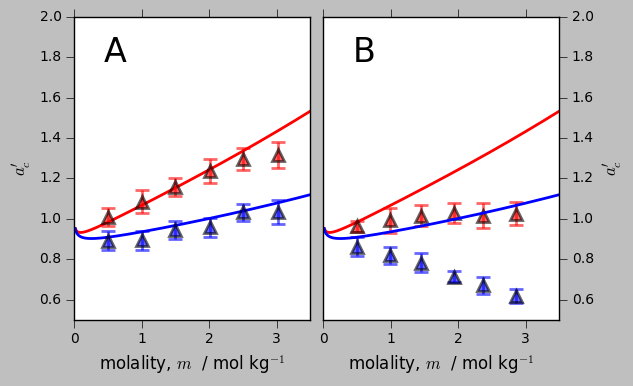

In [9]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 12, 'figure.figsize': [6.5, 4],'xtick.major.pad':3, 'ytick.major.pad':3,
                     'xtick.major.size':6, 'ytick.major.size':6, 'legend.frameon':False,
                     'xtick.direction':'out','ytick.direction':'out','xtick.labelsize':10,'ytick.labelsize':10})

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=False, sharey=False)

# Here, we call the function actDer defined above. Choose which forcefield(s), watermodel(s), ion pair(s) and correction factor(s) you wish to plot. 
actDer('ff_our','spce','Na','SCN','S','Hess',ax1)
actDer('ff_our','spce','K','SCN','S','Hess',ax1)
actDer('ff_bian','spce','Na','SCN','S','Hess',ax2)
actDer('ff_bian','spce','K','SCN','S','Hess',ax2)

ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")            
ax1.set_xticks([0,1,2,3])

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xticks([0,1,2,3])

ax1.annotate('A',xy=(0.125,.85), fontsize=24, xycoords='axes fraction')
ax2.annotate('B',xy=(0.125,.85), fontsize=24, xycoords='axes fraction')
plt.tight_layout(w_pad=.5)
plt.show()

## Calculating $\Delta N_{+-}$
In the next cells, we will finally compute the excess cation-anion numbers, $\Delta N_{+-}$. This is done by integrating the cation-ion RDF, $\Delta g_{+-}$, instead of the ion-ion and water-ion RDFs, $\Delta g_{cc}$ and $\Delta g_{wc}$, as we have done before. The purpose is to evaluate the difference in how the cations (Na$^{+}$ and K$^{+}$) pair with the studied anions.

In [10]:
# Importing necessary packages
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline

def IonPair(rho_an, N_c, g_ca, V, cation, anion, limits=np.array([0])):
    truncInd = 100
    order = 4
    r = np.arange(0, len(g_ca)*0.01, 0.01)
    dr = r[1]-r[0]
    N_ca = rho_an * 4 * pi * np.trapz( ( g_ca - 1 ) * r ** 2, r ) 
    Vn = 4*pi/3*r**3 / V # Calculating vector with remaining volume, which depends on r
    corr_func = N_c / 2 * ( 1 - Vn ) / ( N_c / 2 * ( 1 - Vn ) - N_ca - 0) 
    corr = corr_func[truncInd] 
    g_ca_corr = g_ca * corr # Calculating the corrected cation-anion rdf
    
    if limits.size == 1:
        limits = np.append(limits, argrelextrema(g_ca_corr, np.less, order = order))
        limits = np.append(limits[:4],truncInd)
        # Last index given manually since it could not be obtained for the SCN salts with the function used above
        if cation is 'Na' and anion is 'SCN':
            limits[2] = 65
            limits[3] = 86
        if cation is 'K' and anion is 'SCN':
            limits[1] = 55
            limits[2] = 75
            limits[3] = 93
    N_pair_all = np.empty(0) 
    # Initializing variable representing the sum of all partial excess cation-anion coordination numbers
    for i in range(limits.size-1):
        b = limits[i]
        e = limits[i+1]
        # Calculating running integral describing the current partial 
        # excess cation-anion coordination number, CIP, SIP or 2SIP
        N_ca_corr_part = np.trapz( ( g_ca_corr[b:e] - 1 ) *r[b:e]*r[b:e], r[b:e] )
        # Taking the last value of the running integral to obtain the partial 
        # excess cation-anion coordination number 
        N_pair_all = np.append(N_pair_all, rho_an * 4 * pi * N_ca_corr_part)
    # Calculating the sum of all partial excess cation-anion coordination numbers
    # Calculating the full excess cation-anion coordination number
    N_ca_corr = np.trapz( ( g_ca_corr[:truncInd] - 1 ) * (r[:truncInd] ** 2), r[:truncInd] )
    N_pair_all = np.append(N_pair_all, rho_an * 4 * pi * N_ca_corr)
    # Assigning values to variables representing partial excess cation-anion 
    # coordination numbers (CIP, SIP and 2SIP)
    # Creating vector storing CIP, SIP, 2SIP and the full excess cation-anion coordination numbers

    return N_pair_all, limits, g_ca_corr

In [11]:
def PlotIonPair(ff,cations,anions,rdfAtoms,conc_m,subplot):  
    xpos = 0.5
    xpos_avg = 0
    yposMin = 0
    yposMax = 0
    for anIndex, anion in enumerate(anions):
        minVal = 10
        for cation in cations:
            wdir_sim_data = 'data/ff_our/spce/'+cation.lower()+anion.lower()+'/'+ str(conc_m)+'m/'
            block_range = np.arange(1,10,1)
            
            cnt = 0 # Initializing index to make trajectory only to be read once
            
            g_ca_avg = 0 # Initializing radial distribution function of anions around cations
            V_avg = 0
            rho_c_avg = 0
            rho_w_avg = 0
            N_pair_all = np.empty(0)
            
            for block in block_range: 
                if os.path.isfile( wdir_sim_data+'g_+-_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):  # if pickle files exist, use those
                    g_ca = np.loadtxt(wdir_sim_data+'g_+-_'+str(block))
                    g_ca_avg = g_ca_avg+g_ca/len(block_range)
                    r = np.loadtxt(wdir_sim_data+'r_'+str(block))
                    V = np.loadtxt(wdir_sim_data+'V_'+str(block))
                    V_avg = V_avg + V/len(block_range) 
                    rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
                    rho_c_avg = rho_c_avg + rho_c/len(block_range)
                    #rho_w = np.loadtxt(wdir+'rho_w_'+str(block))
                    #rho_w_avg = rho_w_avg + rho_w/len(block_range)
                
                # if simulation output files exist, use those
                elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):

                    # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
                    while (cnt < 1):
                        
                        import mdtraj as md
                        
                        struct = md.load_pdb(wdir_sim_data+'out.pdb')
                        N_c = len(struct.topology.select('name '+rdfAtoms[anIndex]+' or name '+cation)) # Number of ions
                        
                        sel = struct.topology.select('name '+cation+' or name '+rdfAtoms[anIndex])

                        print("Reading in trajectory...")
                        traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                        nbrFrames = traj.n_frames
                        start = nbrFrames/10
                        traj_equil = traj[start:nbrFrames]
                        print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)

                        cnt = cnt + 1

                    startFrac = start / nbrFrames

                    end = nbrFrames - start
                    first = start + (block-1)*end/len(block_range)
                    last = start + block*end/len(block_range)

                    traj_block = traj[first:last]
                    print("Number of frames in trajectory block: ", traj_block.n_frames)

                    # Analysis: Calculating RDFs
                    r_max = 2.80

                    pair_ca = traj.topology.select_pairs('name '+cation, 'name '+rdfAtoms[anIndex])
                    r, g_ca = md.compute_rdf(traj, pair_ca, r_range=[0,r_max], bin_width=0.01, periodic=True)

                    g_ca_avg = g_ca_avg+g_ca/len(block_range) # Average cation-anion rdf

                    # Computing volume using box vectors
                    V = 0
                    for vec in traj.unitcell_lengths:
                        V = V + vec[0]*vec[1]*vec[2] / traj.n_frames # Volume for current block

                    V_avg = V_avg + V/len(block_range) # Average volume (nm³)

                    # Computing number density of ions
                    rho_c = N_c / V # Number density of anions in current block (nm⁻³)
                    rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of anions (nm⁻³)

                    for (file_name, var) in zip([wdir_sim_data+'g_+-_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_ca, r, V, rho_c]):

                        if file_name in ( wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block) ):
                            f = open( file_name, 'w' )
                            f.write( repr(var) + '\n' )
                            f.close()
                            print("pickle", file_name, "created")
                        else: 
                            np.savetxt(file_name, var)
                            print("pickle", file_name, "created")
                
                else:
                    print("The necessary files are not available in the current working directory")
                
                N_c = rho_c*V 
                rho_an = rho_c/2
                N_pair_block, lims, g_ca_corr = IonPair(rho_an, N_c, g_ca, V, cation, anion)
                N_pair_all = np.append(N_pair_all, N_pair_block)
                
            N_pair, lims, g_ca_corr = IonPair(rho_an, N_c, g_ca_avg, V, cation, anion)
            print(anion,cation,lims)
            N_pair_all = N_pair_all.reshape((block_range.size,N_pair.size)).T
            N_pair_avg = np.average(N_pair_all,axis=1)
            N_pair_std = np.std(N_pair_all,axis=1)

            # Defining value to use for positioning of text below bars
            if minVal > np.min(N_pair_avg):
                minVal = np.min(N_pair_avg) 

            if cation is cations[-1]:
                if minVal > 0:
                    minVal = 0

            # Defining values used for positioning of the bar that is going to be plotted
            if cation is cations[0]:
                xpos = xpos+0.15
                xpos_avg = xpos

            else:
                xpos_avg = xpos
                xpos = xpos+0.065
                xpos_avg = (xpos_avg + xpos)/len(cations)

            # Plotting bars representing partial and full excess cation-anion coordination numbers
            if anion is anions[-1] and cation is cations[-1]:
                subplot.bar(xpos, N_pair_avg[4] , width=0.045/2, edgecolor='crimson', color='crimson', 
                            label='$\Delta N_{+-}$'  , align='center', alpha = 1.0, yerr=N_pair_std[4], capsize=4) 
                subplot.bar(xpos, N_pair_avg[0], width=0.035/2, edgecolor='indigo', color='white',  ecolor='indigo', 
                            label='$\Delta N_{CIP}$', align='center', hatch = '/////', fill=True, alpha = 1.0,
                            yerr=N_pair_std[0], capsize=4) 
                subplot.bar(xpos, N_pair_avg[1], width=0.025/2, edgecolor='navy',   color='navy',   
                            label='$\Delta N_{SIP}$' , align='center', alpha = 1.0, yerr=N_pair_std[1], capsize=4)
                subplot.bar(xpos, N_pair_avg[2], width=0.015/2, edgecolor='pink',   color='white',  ecolor='pink', 
                            label='$\Delta N_{2SIP}$', align='center', hatch = '\\\\', fill=True, alpha = 1.0,
                           yerr=N_pair_std[2], capsize=4)

            else:
                subplot.bar(xpos, N_pair_avg[4] , width=0.045/2, edgecolor='crimson', color='crimson', 
                            align='center', alpha = 1.0, yerr=N_pair_std[4], capsize=4) 
                
                subplot.bar(xpos, N_pair_avg[0] , width=0.035/2, edgecolor='indigo', color='white',  ecolor='indigo', 
                            align='center', hatch = '/////', fill=True, alpha = 1.0,
                           yerr=N_pair_std[0], capsize=4) 
                subplot.bar(xpos, N_pair_avg[1] , width=0.025/2, edgecolor='navy',   color='navy',   
                            align='center', alpha = 1.0, yerr=N_pair_std[1], capsize=4)
                subplot.bar(xpos, N_pair_avg[2], width=0.015/2, edgecolor='pink',   color='white',  ecolor='pink', 
                            align='center', hatch = '\\\\', fill=True, alpha = 1.0,
                           yerr=N_pair_std[2], capsize=4)

                subplot.axhline(y=0, color='k',lw=2)
                subplot.set_xticks([])

            # Plotting text above bars
            subplot.text(xpos, np.max(N_pair_avg) + N_pair_std[4] + 0.01, cation+'$^+$', ha='center', va='bottom') 
            if cation is cations[-1]:
                # Plotting text below bars
                subplot.text(xpos_avg, -.07, anion+'$^-$', ha='center', va='bottom') 
                subplot.legend(loc=0, frameon=False) # Plotting legend
                subplot.set_ylabel('$\Delta N$') # Plotting label of y-axis
 


In [12]:
def IonPairRDF(ff,cation,anion,rdfAtom,conc_m,subplot):
    
    """ This function plots RDFs with a color scheme showing the intervals of radial distances 
    used in the ion-paring analysis. It takes four arguments:
    - cation: 'K' or 'Na'
    - anion: 'Cl', 'I', 'SCN'
    - ff - i.e. force field: 'ff_our' (the ff developed for this paper) or 'ff_bian' (the one by Bian et al.)
    - subplot: Axes object specifying the subplot """
                        
    wdir_sim_data = 'data/ff_our/spce/'+cation.lower()+anion.lower()+'/'+ str(conc_m)+'m/'
    
    # Defining number of blocks to read in from the trajectory (in total 18 blocks)
    block_range = np.arange(1,10,1)
    
    cnt = 0 # Initializing index to make trajectory only to be read once
    
    g_ca_avg = 0 # Initializing radial distribution function of ion around ion
    V_avg = 0
    rho_c_avg = 0
    rho_w_avg = 0
    N_pair_all = np.empty(0)
    
    for block in block_range: 
        if os.path.isfile( wdir_sim_data+'g_+-_'+str(block) ) and os.path.isfile( wdir_sim_data+'r_'+str(block) ) and os.path.isfile( wdir_sim_data+'V_'+str(block) ) and os.path.isfile( wdir_sim_data+'rho_c_'+str(block) ):  # if pickle files exist, use those
            g_ca = np.loadtxt(wdir_sim_data+'g_+-_'+str(block))
            g_ca_avg = g_ca_avg+g_ca/len(block_range)
            r = np.loadtxt(wdir_sim_data+'r_'+str(block))
            V = np.loadtxt(wdir_sim_data+'V_'+str(block))
            V_avg = V_avg + V/len(block_range) # Calculating average among blocks
            rho_c = np.loadtxt(wdir_sim_data+'rho_c_'+str(block))
            rho_c_avg = rho_c_avg + rho_c/len(block_range)
        
        # if simulation output files exist, use those
        elif os.path.isfile( wdir_sim_data+'out.pdb' ) and os.path.isfile( wdir_sim_data+'out.dcd' ):

            # Computing properties based on structure (out.pdb) trajectory file (out.dcd) obtained from simulation protocol
            while (cnt < 1):
                
                import mdtraj as md
                
                struct = md.load_pdb(wdir_sim_data+'out.pdb')
                N_c = len(struct.topology.select('name '+rdfAtoms[anIndex]+' or name '+cation)) # Number of ions

                sel = struct.topology.select('name '+cation+' or name '+rdfAtoms[anIndex])

                print("Reading in trajectory...")
                traj = md.load_dcd(wdir_sim_data+'out.dcd', top = struct, atom_indices = sel)

                nbrFrames = traj.n_frames
                start = nbrFrames/10
                traj_equil = traj[start:nbrFrames]
                print("Number of frames in equilibrated trajectory: ", traj_equil.n_frames)

                cnt = cnt + 1

            startFrac = start / nbrFrames

            end = nbrFrames - start
            first = start + (block-1)*end/len(block_range)
            last = start + block*end/len(block_range)

            traj_block = traj[first:last]
            print("Number of frames in trajectory block: ", traj_block.n_frames)

            # Analysis: Calculating RDFs
            r_max = 2.80

            pair_ca = traj.topology.select_pairs('name '+cation, 'name '+rdfAtoms[anIndex])
            r, g_ca = md.compute_rdf(traj, pair_ca, r_range=[0,r_max], bin_width=0.01, periodic=True)

            g_ca_avg = g_ca_avg+g_ca/len(block_range) # Average cation-anion rdf

            # Computing volume using box vectors
            V = 0
            for vec in traj.unitcell_lengths:
                V = V + vec[0]*vec[1]*vec[2] / traj.n_frames # Volume for current block

            V_avg = V_avg + V/len(block_range) # Average volume (nm³)

            # Computing number density of ions
            rho_c = N_c / V # Number density of anions in current block (nm⁻³)
            rho_c_avg = rho_c_avg + rho_c/len(block_range) # Average number density of anions (nm⁻³)

            for (file_name, var) in zip([wdir_sim_data+'g_+-_'+str(block), wdir_sim_data+'r_'+str(block), wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block)], [g_ca, r, V, rho_c]):

                if file_name in ( wdir_sim_data+'V_'+str(block), wdir_sim_data+'rho_c_'+str(block) ):
                    f = open( file_name, 'w' )
                    f.write( repr(var) + '\n' )
                    f.close()
                    print("pickle", file_name, "created")
                else: 
                    np.savetxt(file_name, var)
                    print("pickle", file_name, "created")

        else:
            print(wdir_sim_data)
            print("The necessary files are not available in the current working directory")
    
    
    N_c = rho_c*V # Obtaining the number of ions in the system
    rho_an = rho_c/2 # Obtaining the number of anions in the system

    N_pair_block, lims, g_ca_corr = IonPair(rho_an, N_c, g_ca, V, cation, anion)
    N_pair_all = np.append(N_pair_all, N_pair_block)
    N_pair, lims, g_ca_corr = IonPair(rho_an, N_c, g_ca_avg, V, cation, anion)
    
    if cation is 'Na':
        color = 'g'
    elif cation is 'K':
        color = 'b'
    subplot.set_ylabel('$g(r)$')
    r = np.arange(0, len(g_ca_corr)*0.01, 0.01)
    subplot.plot(r, g_ca_corr, color, lw=3, label=cation+anion)
    subplot.fill_between(r[lims[0]:lims[1]], 0, g_ca_corr[lims[0]:lims[1]], facecolor='None', edgecolor='indigo', hatch='/////')
    subplot.fill_between(r[lims[1]:lims[2]], 0, g_ca_corr[lims[1]:lims[2]], color='navy')
    subplot.fill_between(r[lims[2]:lims[3]], 0, g_ca_corr[lims[2]:lims[3]], facecolor='None', edgecolor='pink', hatch = '\\\\')
    subplot.fill_between(r[lims[3]:lims[4]], 0, g_ca_corr[lims[3]:lims[4]], color='crimson')
    subplot.set_xlim(0.2, 1.1)
    subplot.set_yticks([0,4,8])
    subplot.set_xticks([.3,.6,.9])
    subplot.set_ylim(-2.5, 11.5)
    subplot.legend(loc='upper right',handlelength=1, handletextpad=0.5)

SCN Na [  0  38  65  86 100]
SCN K [  0  55  75  93 100]


/home/vidar/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Cl Na [  0  36  60  83 100]
Cl K [  0  48  70  95 100]


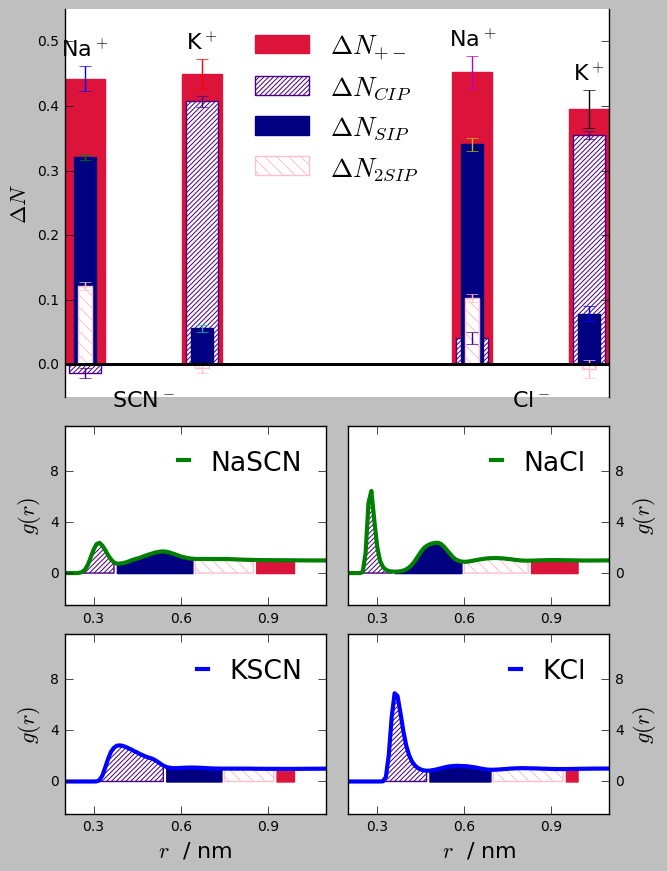

In [13]:
for conc_m in [2.0]:#[0.5,1.0,2.0,3.0]:
    
    plt.rcParams.update({'font.size': 16, 'figure.figsize': [7.0, 9],'xtick.major.pad':4, 'ytick.major.pad':4,
                     'xtick.major.size':6, 'ytick.major.size':6, 'legend.frameon':False,
                     'xtick.direction':'in','ytick.direction':'in'})

    ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2,rowspan=2)
    ax2 = plt.subplot2grid((4, 2), (2, 0))
    ax3 = plt.subplot2grid((4, 2), (3, 0))
    ax4 = plt.subplot2grid((4, 2), (2, 1))
    ax5 = plt.subplot2grid((4, 2), (3, 1))

    PlotIonPair('ff_our',['Na','K'],['SCN','Cl'],['C','Cl'],conc_m,ax1)
    ax1.tick_params(labelbottom='off')
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_ylim(-.05,.55)
    IonPairRDF('ff_our','Na','SCN','C',conc_m,ax2)
    #ax2.set_ylim(0,8)
    IonPairRDF('ff_our','K','SCN','C',conc_m,ax3)
    #ax3.set_ylim(0,8)
    ax3.set_xlabel('$r$  / nm')
    IonPairRDF('ff_our','Na','Cl','Cl',conc_m,ax4)
    #ax4.set_ylim(0,8)
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    IonPairRDF('ff_our','K','Cl','Cl',conc_m,ax5)
    #ax5.set_ylim(0,8)
    ax5.yaxis.tick_right()
    ax5.yaxis.set_label_position("right")
    ax5.set_xlabel('$r$  / nm')

    plt.tight_layout(w_pad=1,h_pad=.5)
    plt.savefig('ionpairs_{:1.0f}'.format(conc_m)+'m.pdf')
    plt.show()

We interpret the plot produced in the last cell to evaluate the difference in how the different ions pair. The first region from the left in the associated RDFs represents $N_{CIP}$, the second $N_{SIP}$, the third $N_{2SIP}$ and the fourth the constant $C$, which adds the last part of the integrated RDF, up to the truncation distance which is 1.0nm, to the total excess cation-anion coordination number, $N_{+-}$. This means that the four regions together represent $N_{+-}$, which is plotted in red in the bar diagram.